In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import hashlib

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230620',
              'user':'student', 
              'password':'dpo_python_2020'
             }

query = '''
select exp_group,
       user_id, 
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes,
       likes / views as ctr
from {db}.feed_actions 
where toDate(time) between toDate('2023-05-31') and toDate('2023-06-06')
and exp_group in (2, 1)
group by exp_group, user_id 
'''

df = ph.read_clickhouse(query, connection=connection)

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Примерно по 10 тысяч пользователей в каждой из групп:

In [3]:
df.exp_group.value_counts()

exp_group
1    10079
2     9952
Name: count, dtype: int64

Для начала стоит рассмотреть распределение метрики по двум группам

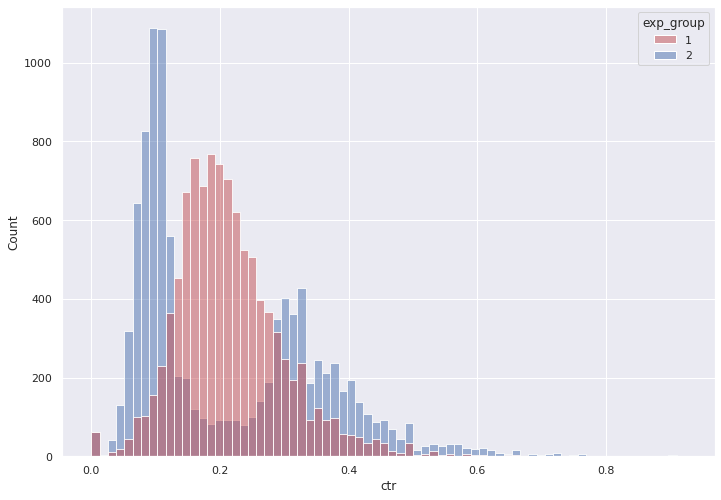

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
                      x='ctr',
                      hue='exp_group', 
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Получили интересное и очевидно разное распределение метрики по группам, по которому уже можно сделать определенные выводы о проведенном эксперименте по внедрению нового алгоритма. А именно, что алгоритм очевидно влияет на ключевую метрику - распределение второй группы стало "менее нормальным" и "двугорбым". При этом в первую вершину попали существенно более низкие значения ключевой метрики (CTR ~ 0.1), к тому же и с бОльшим числом наблюдений (более 1 тыс.), как относительно второй вершины (CTR ~ 0.3 и кол. наблюдений порядка 400), так и относительно единой вершины контрольной 1ой группы (0,2 и ок. 600 соотв.) - все это указывает, что новый алгоритм привел к значительному изменению ключевой метрики у тестовой группы, однако данное изменение было скорее в негативную сторону (визуально по гистограмме CTR 2ой тестовой группы ниже, чем у контрольной, в связи с "перетягиванием" показателя в меньшую сторону более высокой вершиной)

Посмотрим, как отработают тесты на группах

1. T-тест

In [6]:
stats.ttest_ind(df.query('exp_group == 1').ctr, 
                df.query('exp_group == 2').ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Тест не показал значимых отличий между группами - pvalue составил 0,48, что при принятом уровне значимости 0,05 не позволяет отклонить нулевую гипотезу о принадлежности двух групп единой генеральной совокупности. Скорее всего, причина как раз кроется в характере полученного распределения у 2ой группы, а именно - оно сильно скошено за счет первого "горба", а также опять же из-за такой специфичной "двугорбости" в распределении очень высока вероятность больших по модулю отклонений (жирные выбросы — часть распределения). Все это делает не совсем рабочим вариант использовать обычный t тест на необработанных данных "как есть" - использование в таком виде повышает риски получить ошибку второго рода (принять неверную нулевую гипотезу).

Посмотрим на работу иных тестов

2. Тест Манна-Уитни

In [7]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                   df[df.exp_group == 1].ctr)

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

Непараметрический тест Манна-Уитни показал значимые отличия между группами - pvalue существенно меньше принятого уровня значимости, что дает основания отклонить нулевую гипотезу. И действительно, с учетом того как он работает (нулевая гипотеза звучит как равенство вероятностей двух противоположных сравнений: 1)получения значения из 1ой группы больше значения из 2ой группы и 2)получения значения из 2ой группы больше значения из 1ой), даже визуально по распределениям значений заметно, что данные вероятности равны не будут.

3. Сглаженный CTR (α=5) 

Рассчитаем сглаженные значения метрики и построим гистаграмму их распределения

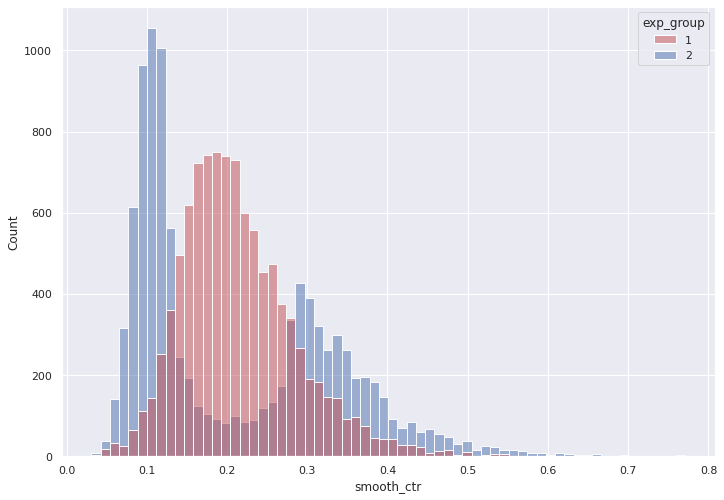

In [8]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

smooth_ctr_1 = df[df.exp_group == 1].apply(lambda x: get_smoothed_ctr(x['likes'],
                                                                      x['views'],
                                                                      global_ctr_1,
                                                                      5), 
                                           axis=1)
smooth_ctr_2 = df[df.exp_group == 2].apply(lambda x: get_smoothed_ctr(x['likes'],
                                                                      x['views'],
                                                                      global_ctr_2,
                                                                      5), 
                                           axis=1)

df['smooth_ctr'] = smooth_ctr_1
df.loc[df.exp_group == 2, 'smooth_ctr'] = smooth_ctr_2

groups = sns.histplot(data = df, 
                      x='smooth_ctr', 
                      hue='exp_group', 
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

С применением данной методики сглаживания экстремальные значения показателя приблизились к общегрупповой величине - сравнивая данную гистограмму с первой, заметно, что нулевые значения устранились, правый "хвост" распределений так же уменьшился.

Рассчитаем тесты на сглаженных значениях метрики.

In [9]:
stats.ttest_ind(smooth_ctr_1, 
                smooth_ctr_2,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.022376981555855876)

Как видим, на сглаженных значения t тест уже показывает более реалистичную картину - pvalue уже менее уровня значимости, что дает основания отклонить нулевую гипотезу о равенстве средних. Возможно, это обусловлено тем, что сглаженные значения показателя в 1ой группе стали еще ближе к центру его распределения, дисперсия уменьшилась, а распределение в целом еще ближе приблизилось к нормальному. Все это позволило t тесту более четко идентифицировать различие между распределениями в группах.

In [10]:
stats.mannwhitneyu(smooth_ctr_1, 
                   smooth_ctr_2)

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

Тест Манна-Уитни так же показал еще большее различие между группами

4. Пуассоновский бутстреп

Рассчитаем по 2000 общегрупповых показателей CTR для каждой из двух групп на основе имитации формирования подвыборок из каждой из них.

In [11]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

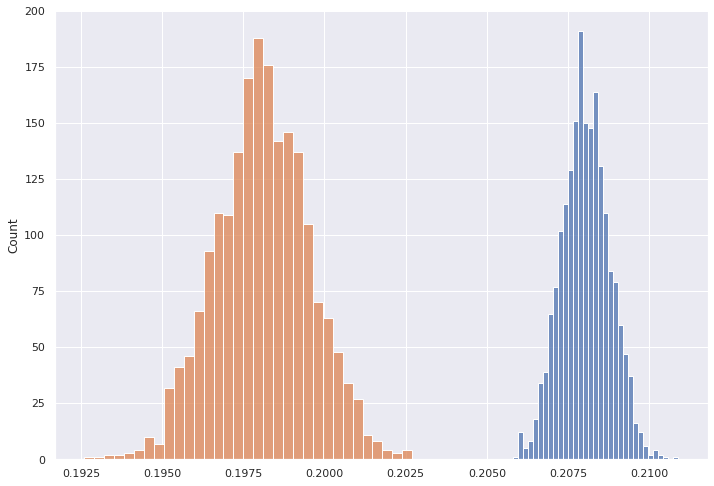

In [15]:
sns.histplot(ctr1)
sns.histplot(ctr2);

Как видим общегрупповые CTR, полученные формированием случайных подвыборок из каждой из групп, распределяются в значительном отдалении друг от друга и даже не пересекаются между собой, что так же является твердым свидетельством верности гипотезы Н1 о принадлежности выборок разным генеральным совокупностям. 

Кроме того, характерно проявляется "ширина" распределения каждой из групп - как следует из самой первой гистограммы, у 1ой группы одна вершина, вокруг которой сформировано большинство наблюдений (более приближено к нормальному распределению), когда как по 2ой группе две вершины более "раздвигают" дисперсию в разные стороны. Соответствующе ведут себя и сформированные подвыборки - дисперсия подвыборочных CTR из 1ой группы визуально гораздо "уже", чем из 2ой группы.

По данной гистограмме следует подчеркнуть и второе важное наблюдение - распределение подвыборочных CTR из контрольной 1ой группы находится правее распределения 2ой группы, что дополнительно подтверждает изначальный вывод, сделанный на основе предварительного анализа распределения CTR по группам - а именно, внедрение нового алгоритма негативно сказалось на исследуемой метрике (CTR по тестовой группе ниже, чем по контрольной).

Для наглядности гистограмма распределения разниц подвыборочных CTR из 2ой и 1ой групп - значения отрицательны:

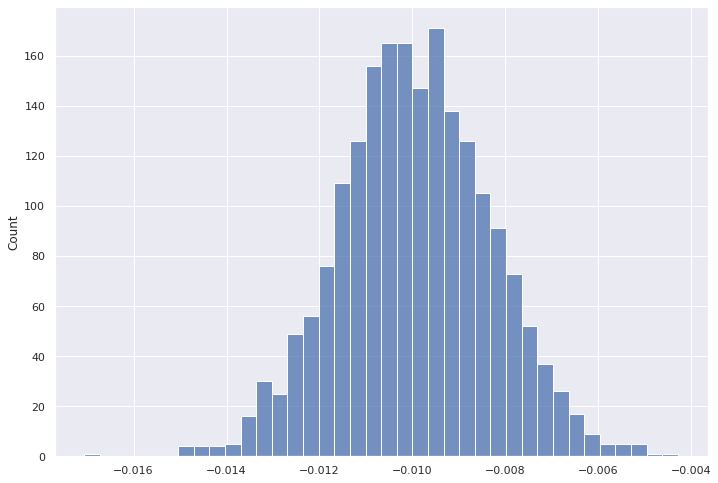

In [17]:
sns.histplot(ctr2 - ctr1);

5. Тесты поверх бакетного преобразования

Распределим всех юзеров по 50 подгруппам на основе их id с применением "соли" детерминированным способом:

In [18]:
def ab_split(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

df['bucket'] = df.user_id.apply(ab_split)

Расчитаем общий показатель CTR по каждой из подгрупп для тестовой и контрольной группы (метрика по "мета-пользователям") и посторим гистаграмму их распределений:

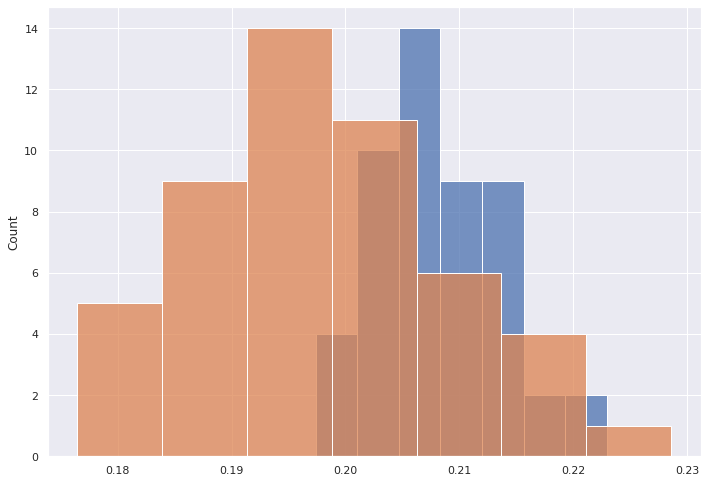

In [20]:
bucket_ctr = df.groupby(['exp_group', 'bucket']).likes.sum() / df.groupby(['exp_group', 'bucket']).views.sum()
sns.histplot(bucket_ctr[1].values)
sns.histplot(bucket_ctr[2].values);

Распределение "побакетного" CTR так же наводит на аналогичные выводы - распределения выглядят неодинаково, а так же метрика тестовой группы ниже контрольной (ее вершина распределения расположена левее вершины контрольной)

Рассчитаем тесты на основе бакетных CTR

In [21]:
stats.ttest_ind(bucket_ctr[1].values, 
                bucket_ctr[2].values,
                equal_var=False)

Ttest_indResult(statistic=5.741526456221474, pvalue=1.937624902064435e-07)

In [22]:
stats.mannwhitneyu(bucket_ctr[1], 
                   bucket_ctr[2])

MannwhitneyuResult(statistic=1993.0, pvalue=3.0771207101702053e-07)

Получены наиболее значимые различия по t тесту (по сравнению с двумя первыми) и менее значимые различия по тесту Манна-Уитни (хотя все так же он зафиксировал значимость различий), что в целом, можно объяснить использованием в тестах "агрегированных" метрик по подгруппам-бакетам, что в случае t теста подчеркивает различия между выборками (различия распределений более выраженны), а в случае теста Манна-Уитни из-за ранговых сравнений (один общий ранг присваивается всему бакету, а не отдельно свой ранг по каждому пользователю) оценки так же обобщаются и различия распределений становятся менее явными.

ИТОГОВЫЙ ВЫВОД:

Из всех проведенных тестов значимых различий не показал только самый первый t тест, примененный к необработанным данным - как уже был сделан вывод, причина кроется в специфике распределения метрики в тестовой группы, в связи с чем можно считать его неприменимым в таком виде и возможным пренебречь его результатами.

Все остальные тесты показали значимые различия - более того, различия оказались в негативную сторону, противоположно ожиданиям - основная гипотеза заключалась в том, что новый алгоритм во 2-й группе приведет к увеличению CTR, в то время как фактически бутстреп и бакетные тесты показали негативную разницу (CTR контрольной группы выше тестовой).

Как отмечалось в выводах к первой гистограмме новый алгоритм привел к значительному изменению ключевой метрики у тестовой группы, однако данное изменение было в негативную сторону (визуально по гистограмме CTR тестовой группы ниже, чем у контрольной, в связи с "перетягиванием" показателя в меньшую сторону более высокой вершиной распределения тестовой группы).

Какова причина такого распределения у тестовой группы? (вопрос № 3)

"Двугорбость" распределения с двумя вершинами может свидетельствовать о том, что новый алгоритм рекомендации постов неодинаково повлиял на аудиторию из тестовой группы, входящих в ее разные подгруппы на основании каких-либо иных критериев, т.е. изначальный признак разделения групп на тестовую и контрольную (а именно новый алгоритм применялся/не применялся) вступил во взаимодействие с другими признаками, разделяющими тестовую группу на подгруппы (например, пол, возраст, используемое устройство для приложения и проч.). В результате этого могли образоваться кластеры, состоящие из пользователей, принадлежащих разным подгруппам тестовой группы на основе данных дополнительных признаков, которые по-разному среагировали на новый алгоритм. Учитывая существенную разность высоты двух пиков, данные доп. признаки должны разделять тестовую группу на подгруппы разных размеров - соответственно, это к примеру, не характеристика "пол", т.к. среди пользователей разделение примерно 50/50, например, это может быть используемой устройство (ос - андроид или эппл - первых больше среди наших пользователей). Утрированный пример - новый алгоритм рекомендации постов почему-то решил, что всем пользователям нужно видеть больше постов про эппловскую технику (обзоры, статьи, рейтинги и т.п.), соответственно, большинству пользователей из тестовой группы это не понравилось из-за их приверженности андроид-устройствам, в то время как меньшей подгруппе "яблочников" новые рекомендации зашли, из-за чего получаем CTR с более низким значением и бОльшим количеством наблюдений (первая вершина - андроид пользователи) и второй CTR с более высоким значеним и низким количеством наблюдений (вторая вершина - эппл пользователи).

Рекомендация стоит или не стоит раскатывать новый алгоритм на всех новых пользователей? (вопрос № 4)

Учитывая общее негативное влияние нового алгоритма на CTR, в таком виде раскатывать, конечно, не стоит - скорее всего, в таком случае мы увидим, как впоследствии наша метрика по всему приложению поплывет вниз. Однако, я думаю, что стоит взглянуть подробнее на возможные причины как раз такого специфичного распределения тестовой группы - все-таки вторая вершина находится правее вершины контрольной группы, а значит на какую-то часть тестовой группы новый алгоритм оказал положительное воздействие. Следует понять, на основе какой/каких характеристик сформировалась данная подгруппа, и можем ли мы это как-то использовать в улучшении пользовательского опыта (например, каким-то образом сегментировать аудиторию и выкатывать новые алгоритмы посегментно).